In [1]:
# Auxiliary packages
import numpy as np
import pandas as pd
from numpy import savetxt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# IBM Quantum Experience
from qiskit import IBMQ, pulse, schedule
from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

In [3]:
# Functions that are functional

def getJobData(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.real(job_results.get_memory(i)[qubit] * scale_factor))
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data


def getClosestMultipleSixteen(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require
    durations which are multiples of 16 samples.
    """
    return int(num + 8) - (int(num + 8) % 16)

In [5]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_properties = backend.properties()

qubit = 0

anharmonicity = backend_properties.qubits[qubit][3].value * 1e9

drive_frequency_01 = 4962317255.07658
drive_duration_01 = 544
drive_sigma_01 = 67
drive_amplitude_01 = 0.09281388317671437

drive_frequency_12 = 4618781329.919704
drive_duration_12 = 160
drive_sigma_12 = 40
drive_amplitude_12 = 0.17306617215735373

In [8]:
# X-axis
with pulse.build(backend=backend) as inst_x_halfpi_01:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(drive_frequency_01, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration_01,
                              amp=drive_amplitude_01/2,
                              sigma=drive_sigma_01), drive_chan)
    
gate_x_halfpi_01 = Gate('$X_{\pi/2}^{(01)}$', 1, [])

with pulse.build(backend=backend) as inst_x_pi_01:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(drive_frequency_01, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration_01,
                              amp=drive_amplitude_01,
                              sigma=drive_sigma_01), drive_chan)
    
gate_x_pi_01 = Gate('$X_{\pi}^{(01)}$', 1, [])

# Y-axis
with pulse.build(backend=backend) as inst_y_plus_halfpi_01:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(drive_frequency_01, drive_chan)
    with pulse.phase_offset(np.pi/2, drive_chan):
        pulse.play(pulse.Gaussian(duration=drive_duration_01,
                                  amp=drive_amplitude_01/2,
                                  sigma=drive_sigma_01), drive_chan)
        
gate_y_plus_halfpi_01 = Gate('$Y_{\pi/2}^{(01)}$', 1, [])

with pulse.build(backend=backend) as inst_y_minus_halfpi_01:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(drive_frequency_01, drive_chan)
    with pulse.phase_offset(-np.pi/2, drive_chan):
        pulse.play(pulse.Gaussian(duration=drive_duration_01,
                                  amp=drive_amplitude_01/2,
                                  sigma=drive_sigma_01), drive_chan)
        
gate_y_minus_halfpi_01 = Gate('$Y_{-\pi/2}^{(01)}$', 1, [])

In [9]:
with pulse.build(backend=backend) as inst_x_pi_12:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(drive_frequency_12, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration_12,
                              amp=drive_amplitude_12,
                              sigma=drive_sigma_12), drive_chan)

gate_x_pi_12 = Gate('$X_{\pi}^{(12)}$', 1, [])
                              
with pulse.build(backend=backend) as inst_x_halfpi_12:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(drive_frequency_12, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration_12,
                              amp=drive_amplitude_12/2,
                              sigma=drive_sigma_12), drive_chan)

gate_x_halfpi_12 = Gate('$X_{\pi/2}^{(12)}$', 1, [])

with pulse.build(backend=backend) as inst_x_minus_pi_12:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(drive_frequency_12, drive_chan)
    with pulse.phase_offset(np.pi, drive_chan):
        pulse.play(pulse.Gaussian(duration=drive_duration_12,
                                  amp=drive_amplitude_12,
                                  sigma=drive_sigma_12), drive_chan)

gate_x_minus_pi_12 = Gate('$X_{-\pi}^{(12)}$', 1, [])

with pulse.build(backend=backend) as inst_x_minus_halfpi_12:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(drive_frequency_12, drive_chan)
    with pulse.phase_offset(np.pi, drive_chan):
        pulse.play(pulse.Gaussian(duration=drive_duration_12,
                                  amp=drive_amplitude_12,
                                  sigma=drive_sigma_12), drive_chan)

gate_x_minus_halfpi_12 = Gate('$X_{-\pi/2}^{(12)}$', 1, [])

In [10]:
# Discriminator circuits

# |0> state
ground_circs = QuantumCircuit(1, 1)
ground_circs.measure(0, 0)

# |1> state
one_circs = QuantumCircuit(1, 1)
one_circs.append(gate_x_pi_01, [0])
one_circs.measure(0, 0)
one_circs.add_calibration(gate_x_pi_01, (0,), inst_x_pi_01, [])

# |2> state
two_circs = QuantumCircuit(1, 1)
two_circs.append(gate_x_pi_01, [0])
two_circs.append(gate_x_pi_12, [0])
two_circs.measure(0, 0)
two_circs.add_calibration(gate_x_pi_01, (0,), inst_x_pi_01, [])
two_circs.add_calibration(gate_x_pi_12, (0,), inst_x_pi_12, [])

In [11]:
circs = [ground_circs, one_circs, two_circs]
n = 1
multiple_of_eight = 8*n

ramsey_circuit = QuantumCircuit(1, 1)
ramsey_circuit.append(gate_y_plus_halfpi_01, [0])
for i in range(multiple_of_eight):
    ramsey_circuit.append(gate_x_halfpi_12, [0])
ramsey_circuit.measure(0,0)
ramsey_circuit.add_calibration(gate_y_plus_halfpi_01, (0,), inst_y_plus_halfpi_01, [])
ramsey_circuit.add_calibration(gate_x_halfpi_12, (0,), inst_x_halfpi_12, [])

circs.append(ramsey_circuit)

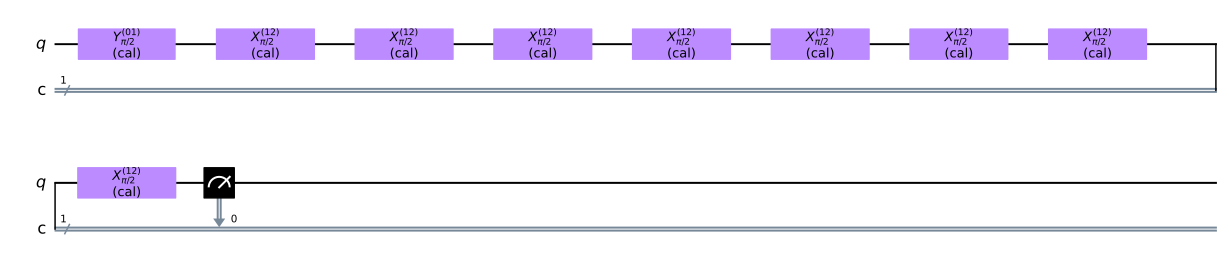

In [12]:
circs[3].draw()

In [ ]:
job = backend.run(circs,
                  meas_level=1,
                  meas_return='single',
                  shots=20000)
print(job.job_id())
job_monitor(job)

6329b555bf8261056300bcab
Job Status: job is queued (21)    